# Assumptions 
#### Both the training and test data sets are multi track MIDI files, but since the assignment says the client is classifying live streamed audio, we are going to assume that the client has an audio to MIDI converter that can't separate tracks. Therefore, we'll combine the tracks in the test set during model building. We are assuming that the streamed MIDI won't have any other data, so we won't use anything else from the training set such as filename or key or instrument. We are also going to assume that they may start streaming MIDI data at any point during the song, not necessarily from the beginning. 

# EDA 
#### We're going to check number of tracks per song (to make sure I interpreted the assignment correctly), and look for class imbalance.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from xgboost import XGBClassifier
import umap
from mido import MidiFile

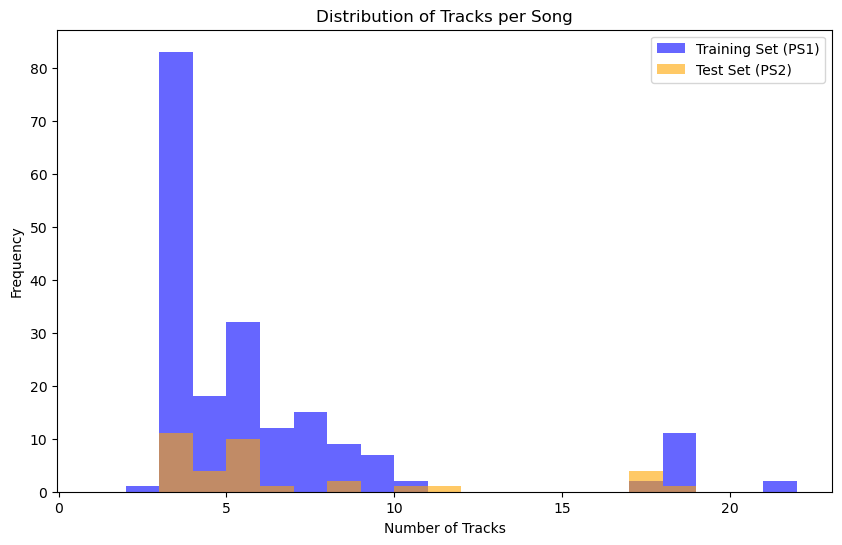

Class Imbalance Check (Training Set):
           Count  Percentage (%)
composer                        
Beethoven    132       68.041237
Schubert      25       12.886598
Brahms        20       10.309278
Bach          17        8.762887


In [2]:
base_dir = "Part One Data"
ps1_dir = os.path.join(base_dir, "Part1(PS1)")
ps2_dir = os.path.join(base_dir, "Part1(PS2)")

def parse_midi_metadata(file_path, composer=None) -> dict:
    '''
    Parses MIDI metadata
    '''
    midi = MidiFile(file_path)
    return {
        "composer": composer,
        "tracks": len(midi.tracks)
    }

ps1_metadata = []
for composer in os.listdir(ps1_dir):
    composer_dir = os.path.join(ps1_dir, composer)
    if os.path.isdir(composer_dir):
        for file in os.listdir(composer_dir):
            if file.endswith(".mid"):
                file_path = os.path.join(composer_dir, file)
                ps1_metadata.append(parse_midi_metadata(file_path, composer=composer))
ps2_metadata = []
for composer in os.listdir(ps2_dir):
    composer_dir = os.path.join(ps2_dir, composer)
    if os.path.isdir(composer_dir):
        for file in os.listdir(composer_dir):
            if file.endswith(".mid"):
                file_path = os.path.join(composer_dir, file)
                ps2_metadata.append(parse_midi_metadata(file_path, composer=composer))

# Put into DataFrames
ps1_df = pd.DataFrame(ps1_metadata)
ps2_df = pd.DataFrame(ps2_metadata)

ps1_tracks = ps1_df["tracks"].dropna().astype(int)
ps2_tracks = ps2_df["tracks"].dropna().astype(int)

# Plot distributions of track count per song, just to check nothing fishy with test vs train.
plt.figure(figsize=(10, 6))
plt.hist(ps1_tracks, bins=range(1, max(ps1_tracks.max(), ps2_tracks.max()) + 2), alpha=0.6, label="Training Set (PS1)", color="blue")
plt.hist(ps2_tracks, bins=range(1, max(ps1_tracks.max(), ps2_tracks.max()) + 2), alpha=0.6, label="Test Set (PS2)", color="orange")
plt.title("Distribution of Tracks per Song")
plt.xlabel("Number of Tracks")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Check for class imbalance
class_counts = ps1_df["composer"].value_counts()
class_percentages = (class_counts / class_counts.sum()) * 100
print("Class Imbalance Check (Training Set):")
print(pd.DataFrame({"Count": class_counts, "Percentage (%)": class_percentages}))


### The distribution of tracks per song looks similar between test and train, so I feel comfortable that combining tracks won't cause any issues (although it will hurt model performance). Unfortunately we have pretty big class imbalance, so we'll use class weighting to accomodate (we could also make some synthetic data, or oversample minority classes, but the built in class weighting usually works well) 

# Functions that have been pulled out for later use 


In [3]:
def chunk_midi(file_path: str, chunk_seconds: int) -> list:
    """
    Splits a MIDI file into chunks.
    Discards any leftover chunk
    Returns a list of chunks, each chunk is a list of MIDI messages.
    """
    midi = MidiFile(file_path)
    chunks = []
    current_chunk = []
    elapsed_time = 0.0

    for msg in midi:
        delta_seconds = msg.time
        elapsed_time += delta_seconds
        current_chunk.append(msg)

        if elapsed_time >= chunk_seconds:
            chunks.append(current_chunk)
            current_chunk = []
            elapsed_time = 0.0

    return chunks

def extract_features_from_chunk(chunk: list) -> dict:
    """
    Extracts pitch & velocity features from a MIDI chunk.
    Returns None if no 'note_on' events.
    Includes some additional stats like median, IQR, etc.
    """
    pitches = []
    velocities = []
    elapsed_time_sec = 0.0
    note_on_count = 0

    for msg in chunk:
        delta_seconds = msg.time
        elapsed_time_sec += delta_seconds
        
        if msg.type == 'note_on' and msg.velocity > 0:
            pitches.append(msg.note)
            velocities.append(msg.velocity)
            note_on_count += 1

    if note_on_count == 0:
        return None

    pitches = np.array(pitches)
    velocities = np.array(velocities)

    pitch_median = np.median(pitches)
    pitch_iqr = np.percentile(pitches, 75) - np.percentile(pitches, 25)
    velocity_median = np.median(velocities)
    velocity_iqr = np.percentile(velocities, 75) - np.percentile(velocities, 25)

    features = {
        "avg_pitch": np.mean(pitches),
        "std_pitch": np.std(pitches),
        "range_pitch": (np.max(pitches) - np.min(pitches)),
        "lowest_pitch": np.min(pitches),
        "highest_pitch": np.max(pitches),
        "pitch_median": pitch_median,
        "pitch_iqr": pitch_iqr,

        "avg_velocity": np.mean(velocities),
        "std_velocity": np.std(velocities),
        "velocity_median": velocity_median,
        "velocity_iqr": velocity_iqr,

        "note_on_count": note_on_count,
        "note_density": note_on_count / (elapsed_time_sec + 1e-9),
        "note_on_rate": note_on_count / 30.0  # chunk ~30s
    }
    return features

def build_feature_dataset(folder_path: str, chunk_seconds: int) -> pd.DataFrame:
    """
    Build a feature DataFrame for each chunk
    """
    data_rows = []
    composers = os.listdir(folder_path)

    for composer_name in composers:
        composer_dir = os.path.join(folder_path, composer_name)
        if not os.path.isdir(composer_dir):
            continue

        for fname in os.listdir(composer_dir):
            if not fname.lower().endswith(".mid"):
                continue

            file_path = os.path.join(composer_dir, fname)
            chunks = chunk_midi(file_path, chunk_seconds)
            for i, chunk in enumerate(chunks):
                feats = extract_features_from_chunk(chunk)
                if feats is not None:
                    feats["composer"] = composer_name
                    feats["filename"] = fname
                    feats["chunk_index"] = i
                    data_rows.append(feats)

    return pd.DataFrame(data_rows)

In [4]:
def predict_composer_with_threshold(model, X, label_encoder, threshold):
    """
    Predict the composer using model.predict_proba(X).
    If the max predicted probability < threshold, label as 'unknown'.
    """
    probs = model.predict_proba(X)
    max_probs = np.max(probs, axis=1)

    preds = []
    class_indices = np.argmax(probs, axis=1)
    for i, p in enumerate(max_probs):
        if p < threshold:
            preds.append("unknown")
        else:
            composer_idx = class_indices[i]
            preds.append(label_encoder.inverse_transform([composer_idx])[0])
    return preds

def plot_metrics_vs_threshold(eval_results):
    """
    Plot FPR, Precision(unknown), Recall(unknown), F1(unknown) across thresholds.
    """
    thresholds = eval_results["threshold"]

    # FPR
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, eval_results["FPR_noLOF"], label="FPR noLOF", marker='o')
    plt.plot(thresholds, eval_results["FPR_withLOF"], label="FPR withLOF", marker='x')
    plt.xlabel("Threshold")
    plt.ylabel("False Positive Rate")
    plt.title("FPR vs. Threshold (Holdout known => 'unknown' is false positive)")
    plt.legend()
    plt.show()

    # Precision(unknown)
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, eval_results["Precision_noLOF"], label="Precision(unknown) noLOF", marker='o')
    plt.plot(thresholds, eval_results["Precision_withLOF"], label="Precision(unknown) withLOF", marker='x')
    plt.xlabel("Threshold")
    plt.ylabel("Precision(unknown)")
    plt.title("Precision(unknown) vs. Threshold (Holdout known)")
    plt.legend()
    plt.show()

    # Recall(unknown)
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, eval_results["Recall_noLOF"], label="Recall(unknown) noLOF", marker='o')
    plt.plot(thresholds, eval_results["Recall_withLOF"], label="Recall(unknown) withLOF", marker='x')
    plt.xlabel("Threshold")
    plt.ylabel("Recall(unknown)")
    plt.title("Recall(unknown) vs. Threshold (Holdout known)")
    plt.legend()
    plt.show()

    # F1(unknown)
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, eval_results["F1_noLOF"], label="F1(unknown) noLOF", marker='o')
    plt.plot(thresholds, eval_results["F1_withLOF"], label="F1(unknown) withLOF", marker='x')
    plt.xlabel("Threshold")
    plt.ylabel("F1(unknown)")
    plt.title("F1(unknown) vs. Threshold (Holdout known)")
    plt.legend()
    plt.show()

In [5]:
def compare_unknown_proportions(model, X_holdout, X_ps2, thresholds=np.linspace(0.1, 0.9, 9), lof_model=None):
    """
    For each threshold, compute fraction labeled unknown in holdout vs. PS2
    with and without LOF. Returns a DataFrame:
    """
    probs_holdout = model.predict_proba(X_holdout)
    max_probs_holdout = np.max(probs_holdout, axis=1)

    probs_ps2 = model.predict_proba(X_ps2)
    max_probs_ps2 = np.max(probs_ps2, axis=1)

    lof_flags_holdout = lof_model.predict(X_holdout) if lof_model else None
    lof_flags_ps2 = lof_model.predict(X_ps2) if lof_model else None

    results = {
        "threshold": [],
        "frac_unk_holdout_noLOF": [],
        "frac_unk_ps2_noLOF": [],
        "frac_unk_holdout_withLOF": [],
        "frac_unk_ps2_withLOF": [],
        "diff_noLOF": [],
        "diff_withLOF": []
    }

    for th in thresholds:
        # no LOF approach
        holdout_unknown_noLOF = (max_probs_holdout < th).astype(int)
        ps2_unknown_noLOF = (max_probs_ps2 < th).astype(int)

        frac_unk_holdout_noLOF = holdout_unknown_noLOF.mean()
        frac_unk_ps2_noLOF = ps2_unknown_noLOF.mean()

        # with LOF approach
        if lof_model is not None:
            # holdout
            holdout_unk_withLOF = []
            for i, prob in enumerate(max_probs_holdout):
                if lof_flags_holdout[i] == -1 or prob < th:
                    holdout_unk_withLOF.append(1)
                else:
                    holdout_unk_withLOF.append(0)
            frac_unk_holdout_withLOF = np.mean(holdout_unk_withLOF)

            # ps2
            ps2_unk_withLOF = []
            for i, prob in enumerate(max_probs_ps2):
                if lof_flags_ps2[i] == -1 or prob < th:
                    ps2_unk_withLOF.append(1)
                else:
                    ps2_unk_withLOF.append(0)
            frac_unk_ps2_withLOF = np.mean(ps2_unk_withLOF)
        else:
            frac_unk_holdout_withLOF = frac_unk_holdout_noLOF
            frac_unk_ps2_withLOF = frac_unk_ps2_noLOF

        diff_noLOF = frac_unk_ps2_noLOF - frac_unk_holdout_noLOF
        diff_withLOF = frac_unk_ps2_withLOF - frac_unk_holdout_withLOF

        results["threshold"].append(th)
        results["frac_unk_holdout_noLOF"].append(frac_unk_holdout_noLOF)
        results["frac_unk_ps2_noLOF"].append(frac_unk_ps2_noLOF)
        results["frac_unk_holdout_withLOF"].append(frac_unk_holdout_withLOF)
        results["frac_unk_ps2_withLOF"].append(frac_unk_ps2_withLOF)
        results["diff_noLOF"].append(diff_noLOF)
        results["diff_withLOF"].append(diff_withLOF)

    return pd.DataFrame(results)

def plot_unknown_proportions_vs_threshold(df_compare):
    """
    Plots fraction-labeled-unknown for holdout vs. PS2 as a function of threshold,
    both for noLOF and withLOF, plus their difference.
    """
    thresholds = df_compare["threshold"]

    plt.figure(figsize=(10,6))
    plt.plot(thresholds, df_compare["frac_unk_holdout_noLOF"], 'o-', label="Holdout Unknown(%) noLOF")
    plt.plot(thresholds, df_compare["frac_unk_ps2_noLOF"], 'x-', label="PS2 Unknown(%) noLOF")
    plt.xlabel("Threshold")
    plt.ylabel("Fraction Labeled Unknown")
    plt.title("Fraction Labeled Unknown vs. Threshold (No LOF)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(thresholds, df_compare["frac_unk_holdout_withLOF"], 'o-', label="Holdout Unknown(%) wLOF")
    plt.plot(thresholds, df_compare["frac_unk_ps2_withLOF"], 'x-', label="PS2 Unknown(%) wLOF")
    plt.xlabel("Threshold")
    plt.ylabel("Fraction Labeled Unknown")
    plt.title("Fraction Labeled Unknown vs. Threshold (With LOF)")
    plt.legend()
    plt.show()


In [6]:
def create_predictions_dataframe(df_in: pd.DataFrame,model,label_encoder,threshold,lof_model=None,is_known_dataset=False):
    """
    Creates predictions dataframe
    """
    # We'll create X from the feature columns
    feature_cols = [c for c in df_in.columns 
                    if c not in ("composer", "filename", "chunk_index")]
    X = df_in[feature_cols].values

    # Probability-based predictions
    probs = model.predict_proba(X)
    max_probs = np.max(probs, axis=1)

    # Threshold-based label
    preds_threshold = predict_composer_with_threshold(model, X, label_encoder, threshold)

    # LOF-based label
    lof_flags = None
    lof_pred = None
    if lof_model is not None:
        lof_flags = lof_model.predict(X)  # +1 = inlier, -1 = outlier
        lof_pred = ["unknown" if f == -1 else "known" for f in lof_flags]

    # Combine threshold + LOF
    combined_pred = []
    if lof_flags is not None:
        for thr_label, lof_label in zip(preds_threshold, lof_pred):
            if thr_label == "unknown" or lof_label == "unknown":
                combined_pred.append("unknown")
            else:
                combined_pred.append(thr_label)
    else:
        combined_pred = preds_threshold

    # output DF
    out_df = pd.DataFrame({
        "filename": df_in["filename"],
        "chunk_index": df_in["chunk_index"],
        "confidence_threshold": [threshold]*len(df_in),
        "max_probability": max_probs,
        "threshold_pred": preds_threshold
    })

    if lof_flags is not None:
        out_df["lof_flag"] = lof_flags
        out_df["lof_pred"] = lof_pred
        out_df["combined_pred"] = combined_pred
    else:
        out_df["combined_pred"] = combined_pred

    if is_known_dataset:
        out_df["true_composer"] = df_in["composer"]  # from the original DataFrame

    return out_df


In [7]:
def train_and_explore(chunk_seconds, RAND_SEED, threshold_value, base_dir, ps1_dir, ps2_dir):

    ###################################################### Build training dataset ##########################################################
    df_train = build_feature_dataset(ps1_dir, chunk_seconds)

    # Separate out "filename", "chunk_index", "composer" from the numeric features, because real client data won't have them.
    feature_cols = [c for c in df_train.columns if c not in ("filename", "chunk_index", "composer")]
    X_all = df_train[feature_cols].values
    y_all = df_train["composer"].values

    # Encode composer as numeric
    le = LabelEncoder()
    y_all_enc = le.fit_transform(y_all)
    n_classes = len(le.classes_)

    # Train/Holdout split. We need a true holdout sample before we do crossval, to check for overfitting.
    df_train_indices, df_holdout_indices = train_test_split(
        np.arange(len(df_train)),
        test_size=0.2,
        random_state=RAND_SEED,
        stratify=y_all_enc)
    
    df_train_indices = sorted(df_train_indices)
    df_holdout_indices = sorted(df_holdout_indices)

    df_train_split = df_train.iloc[df_train_indices].reset_index(drop=True)
    df_holdout_split = df_train.iloc[df_holdout_indices].reset_index(drop=True)

    # X_train, y_train
    X_train = df_train_split[feature_cols].values
    y_train = le.transform(df_train_split["composer"].values)

    # X_holdout, y_holdout
    X_holdout = df_holdout_split[feature_cols].values
    y_holdout = le.transform(df_holdout_split["composer"].values)

    ######################################################## Training Pipeline ############################################################
    pipe = Pipeline([('scaler', StandardScaler()),('clf', RandomForestClassifier(random_state=RAND_SEED))]) # using random forest as a placeholder, because need any model

    param_grid = [
        # Random Forest
        {
            'clf': [RandomForestClassifier(random_state=RAND_SEED)],
            'clf__n_estimators': [50, 100],
            'clf__max_depth': [None, 5, 10],
            'clf__class_weight': [None, 'balanced']
        },
        # SVM
        {
            'clf': [SVC(probability=True, random_state=RAND_SEED)],
            'clf__kernel': ['linear', 'rbf'],
            'clf__C': [0.1, 1.0, 10.0],
            'clf__class_weight': [None, 'balanced']
        },
        # XGBoost
        {
            'clf': [XGBClassifier(eval_metric='mlogloss', random_state=RAND_SEED,
                                  objective='multi:softprob')],
            'clf__n_estimators': [75, 100, 125],
            'clf__max_depth': [6, 7, 8],
            'clf__learning_rate': [0.01, 0.1],
            'clf__gamma': [0.0, 0.1, 0.2],
            'clf__min_child_weight': [1, 5],
        }
    ]

    # Set up for rotational cross validation.
    kf = KFold(n_splits=5, shuffle=True, random_state=RAND_SEED)
    num_cores = max(1, os.cpu_count() - 1)

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=kf,
        n_jobs=num_cores,
        verbose=1,
        return_train_score=True
    )
    grid.fit(X_train, y_train)

    # Summaries
    results_df = pd.DataFrame(grid.cv_results_)
    def get_clf_name(row):
        return type(row['param_clf']).__name__
    results_df['clf_name'] = results_df.apply(get_clf_name, axis=1)

    # Find best models/hyperparameters
    best_rows = []
    for clf_name, group_df in results_df.groupby('clf_name'):
        valid_rows = group_df[group_df['mean_test_score'].notna()]
        if len(valid_rows) == 0:
            continue
        best_idx = valid_rows['mean_test_score'].idxmax()
        best_rows.append(valid_rows.loc[best_idx])

    best_models_df = pd.DataFrame(best_rows).sort_values('mean_test_score', ascending=False)
    print("\n###### Best Hyperparam Combo for Each Classifier ######")
    with pd.option_context("display.max_colwidth", None):
        print(best_models_df[["clf_name", "mean_test_score", "std_test_score", "params"]])

    # Re-train best models)
    best_models = []
    holdout_results = []

    for idx, row in best_models_df.iterrows():
        clf_name = row['clf_name']
        best_params = row['params']
        new_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', best_params['clf'])
        ])
        clone_params = dict(best_params)
        del clone_params['clf']
        new_pipe.set_params(**clone_params)

        new_pipe.fit(X_train, y_train)
        y_pred_holdout = new_pipe.predict(X_holdout)

        acc = accuracy_score(y_holdout, y_pred_holdout)
        prec = precision_score(y_holdout, y_pred_holdout, average='macro', zero_division=0)
        rec = recall_score(y_holdout, y_pred_holdout, average='macro', zero_division=0)
        f1_ = f1_score(y_holdout, y_pred_holdout, average='macro', zero_division=0)

        holdout_results.append({
            'clf_name': clf_name,
            'accuracy': acc,
            'precision_macro': prec,
            'recall_macro': rec,
            'f1_macro': f1_
        })

        cm = confusion_matrix(y_holdout, y_pred_holdout, labels=range(n_classes))
        cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
        print(f"\nConfusion Matrix for {clf_name} on the holdout set:")
        print(cm_df)

        # Store best models and params for later use
        joblib.dump(new_pipe, f"best_{clf_name}.pkl")
        best_models.append((clf_name, new_pipe))

    holdout_df = pd.DataFrame(holdout_results).sort_values('f1_macro', ascending=False)
    print("\n###### Holdout Set Results (Best Version of Each Model) ######")
    print(holdout_df)

    # Pick the top
    top_clf_name = holdout_df.iloc[0]['clf_name']
    print(f"\nThe overall best classifier is {top_clf_name}")

    top_pipeline = None
    for name, model_obj in best_models:
        if name == top_clf_name:
            top_pipeline = model_obj
            break

    # Fit LOF
    lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
    lof.fit(X_train)

    ############################################## Compare unknown proportions: holdout vs. PS2 ############################################
    df_test = build_feature_dataset(ps2_dir, chunk_seconds)
    X_ps2 = df_test[feature_cols].values

    compare_df = compare_unknown_proportions(
        model=top_pipeline,
        X_holdout=X_holdout,
        X_ps2=X_ps2,
        thresholds=np.linspace(0.1, 0.9, 9),
        lof_model=lof
    )

    print('''\n\nBelow is the proportion of songs that were labelled "unknown" in both the training holdout set (which shouldn't have any),
    and the PS2 test set (which should have some). We are looking for a value of the threshold that gives some power to label truely 
    unknown composers, without having a very high false positive rate.''')
    
    plot_unknown_proportions_vs_threshold(compare_df)

    ############################################ Output holdout predictions CSV (single threshold) #########################################
    df_holdout_preds = create_predictions_dataframe(
        df_in=df_holdout_split,
        model=top_pipeline,
        label_encoder=le,
        threshold=threshold_value,
        lof_model=lof,
        is_known_dataset=True
    )
    df_holdout_preds.to_csv("holdout_predictions_with_unknown_composer_model.csv", index=False)

    return top_pipeline, le, lof, X_train, X_holdout, y_train, y_holdout


In [8]:
def run_inference(chunk_seconds, RAND_SEED, threshold_value, base_dir, ps1_dir, ps2_dir, top_pipeline, le, lof, X_train, X_holdout, y_train, y_holdout):
    df_test = build_feature_dataset(ps2_dir, chunk_seconds)
    feature_cols = [c for c in df_test.columns if c not in ("filename", "chunk_index", "composer")]
    X_ps2 = df_test[feature_cols].values

    
    ############################################### Output ps2 predictions CSV (same threshold)) ###########################################
    df_ps2_preds = create_predictions_dataframe(
        df_in=df_test,
        model=top_pipeline,
        label_encoder=le,
        threshold=threshold_value,
        lof_model=lof,
        is_known_dataset=False
    )
    df_ps2_preds.to_csv("ps2_predictions.csv", index=False)

    # Print unique filenames that are unknown
    unknown_rows = df_ps2_preds[df_ps2_preds["combined_pred"] == "unknown"]
    unknown_filenames = unknown_rows["filename"].unique()
    print(f'\nPS2 Files labeled as UNKNOWN at threshold={threshold_value}:, in at least one of their 30 second samples\n')
    for fn in unknown_filenames:
        print("  ", fn)

    ########################################################### PCA Visualization  #########################################################
    X_known_full = np.vstack([X_train, X_holdout])
    y_known_full = np.concatenate([y_train, y_holdout])

    ps2_unknown_mask = (df_ps2_preds["combined_pred"] == "unknown").values

    X_ps2 = df_test[feature_cols].values
    X_combined = np.vstack([X_known_full, X_ps2])

    pca = PCA(n_components=2, random_state=RAND_SEED)
    X_combined_2D = pca.fit_transform(X_combined)

    n_known_total = len(X_known_full)
    X_known_2D = X_combined_2D[:n_known_total]
    X_ps2_2D = X_combined_2D[n_known_total:]

    # Plot known data by composer
    plt.figure(figsize=(9,7))
    for c in np.unique(y_known_full):
        idxs = np.where(y_known_full == c)[0]
        plt.scatter(X_known_2D[idxs,0], X_known_2D[idxs,1],
                    label=f"Known: {le.inverse_transform([c])[0]}",
                    alpha=0.6)

    # Separate PS2 known vs. unknown
    X_ps2_2D_unknown = X_ps2_2D[ps2_unknown_mask]
    X_ps2_2D_known = X_ps2_2D[~ps2_unknown_mask]

    plt.scatter(X_ps2_2D_unknown[:,0], X_ps2_2D_unknown[:,1],
                c='red', marker='X', s=200, label="PS2 (labelled unknown)")

    plt.scatter(X_ps2_2D_known[:,0], X_ps2_2D_known[:,1],
                c='black', marker='x', label="PS2 (labelled known)")

    plt.legend()
    plt.title(f"PCA 2D: Known (train+holdout) vs. PS2,\nthreshold={threshold_value}, LOF integrated")
    plt.show()

In [9]:
# Parameters for running pipeline
chunk_seconds = 30
RAND_SEED = 1
threshold_value = 0.3
base_dir = "Part One Data"
ps1_dir = os.path.join(base_dir, "Part1(PS1)")
ps2_dir = os.path.join(base_dir, "Part1(PS2)")

# Train our model, output some metrics
### Train/holdout split, cross validation of the train portion, grid search of models X hyperparameters, test on holdout. Then add in ability to predict "unknown" classes, and look at how unknown prediction rates relate to thresholds used to call them. Implemented both confidence thresholds and Local Outlier Factor.

Fitting 5 folds for each of 132 candidates, totalling 660 fits

###### Best Hyperparam Combo for Each Classifier ######
                  clf_name  mean_test_score  std_test_score  \
44           XGBClassifier         0.872478        0.018118   
1   RandomForestClassifier         0.825339        0.007239   
21                     SVC         0.822452        0.021113   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

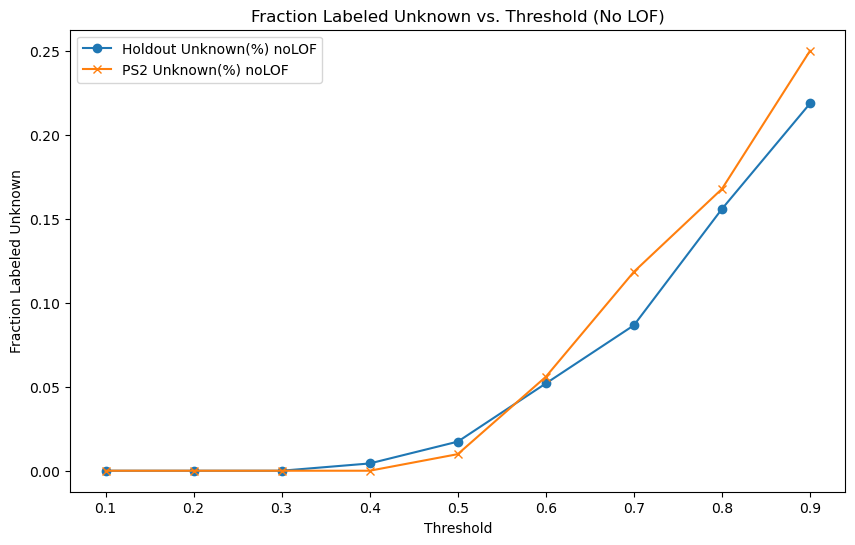

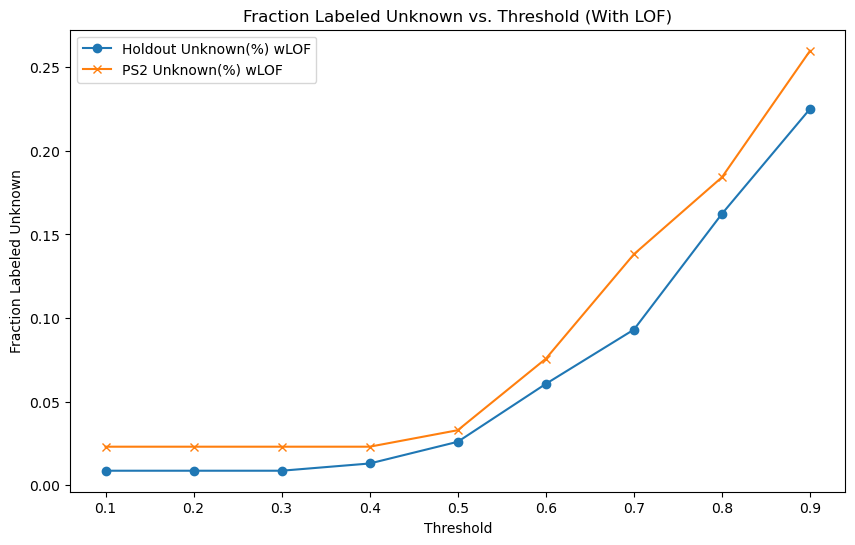

In [10]:
# Train
top_pipeline, le, lof, X_train, X_holdout, y_train, y_holdout = train_and_explore(chunk_seconds, RAND_SEED, threshold_value, base_dir, ps1_dir, ps2_dir)

### At a probability threshold of 0.3, we are not labelling any of the holdout set as "unknown composer". At higher probability thresholds, we are. So, we'll use 0.3 as our cutoff for the final inference. The LOF seems to label about 1/40 songs in the test set as "unknown", while not labelling any in the holdout set, so we'll keep the LOF. We have no measure of our recall, as there is no "unknown composer" training data.

# Run our inference
### Using the best model and the thresholds that we determined above, we will label the PS2 portion of the data set. We'll also plot a PCA of the data in our feature space, to see if our "unknown" labels look reasonable 


PS2 Files labeled as UNKNOWN at threshold=0.3:, in at least one of their 30 second samples

   0.07186746659481313_adj.mid
   0.36321860283443286_adj.mid
   0.3334293069825759_adj.mid


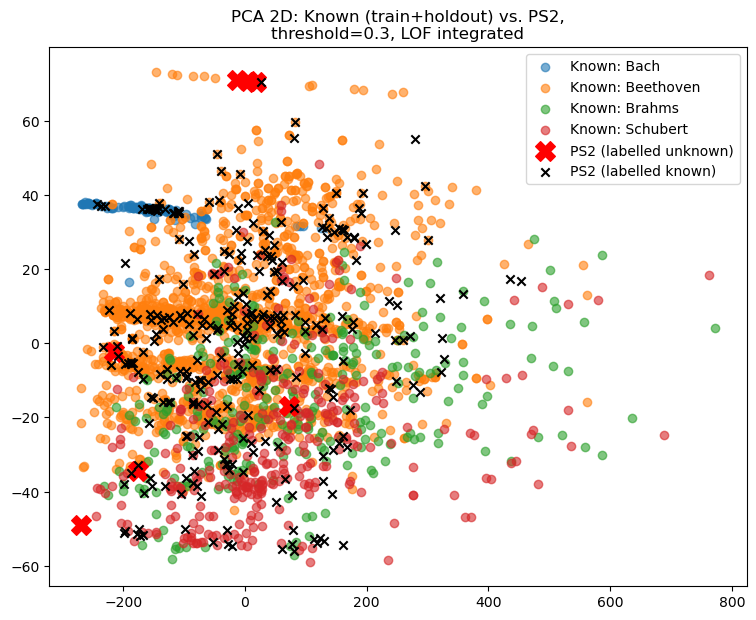

In [11]:
# Label the true test dataset that includes unknown composers
run_inference(chunk_seconds, RAND_SEED, threshold_value, base_dir, ps1_dir, ps2_dir, top_pipeline, le, lof, X_train, X_holdout, y_train, y_holdout)

# Results
### Our model labeled three files as having an unknown composer in at least one 30 second sample. These files were:
### 0.07186746659481313_adj.mid
### 0.36321860283443286_adj.mid
### 0.3334293069825759_adj.mid
### 
### When all the 30 second segments from the files are plotted in a PCA of our feature space, we see that the "unknown" labelled segments do not particularly stand out, which gives me pause in feeling confident that these are truely by a composer other than Bach, Beethoven, Schubert, or Brahms. A full analysis is written up separately. Moreover, when we examine the ps2_predictions.csv, we see that not all 30 second segments from songs labelled as "unknown" are labelled as "unknown", which indicates that even if these are truely unknown composers, there is likely a false negative rate as well.